In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.special import gamma, factorial

STARTING_RANGE_PARAMETER = 0.1 # In [fm^-2]
ENDING_RANGE_PARAMETER = 15
BETA = 0.0000001 # In [fm^-2], can be edited to get a better fit for a realistic density distrbution.
REDUCED_MASS = 935 * 10/11 # In [Mev / c^2], need to update value and units (10/11 A in MeV)
SUM_LIMIT = 20 # Determines the number of gaussians we expand our wave function to
CORE_MS_RADIUS = 2.30**2 # In fm^2, taken from p.232 of Tanihata et. al. (2013)

V_LS = 20.99 # In MeV
DIFFUSIVITY = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_C = 10 # The number of nucleons in the core

CENTRAL_POTENTIAL_PARAMETERS = [0.1, 0.151991, 0.231013, 0.351119, 0.53367, 0.811131, 1.23285,
                                1.87382, 2.84804, 4.32876, 6.57933, 10.]

CENTRAL_MIXING_COEFFICIENTS = [0.0558247,0.214443,2.42773,-0.724055,-2.17761,1.02031,0.819031,-0.96538,0.197094,0.3221,-0.296652,0.093208]

SPIN_ORBIT_POTENTIAL_PARAMETERS = [11.1111, 7.22509, 4.69817, 3.05502, 1.98655, 1.29177, 0.839985,
                                   0.546207, 0.355175, 0.230956, 0.150181, 0.0976562]

SPIN_ORBIT_MIXING_COEFFICIENTS = [0.0125374, -0.0512991, 0.148279, -0.274449, 0.257826, 0.258896,
                                  -1.36588, 1.22003, 2.19945, -3.41816, 0.115793, -0.0785824]

In [2]:
def gaussian_wavefunction(radius, range_parameter, orb_ang_momentum):
    normalisation = (2**(-2.5 - orb_ang_momentum) * (range_parameter)**(3 + 2 * orb_ang_momentum) * gamma(1.5 + orb_ang_momentum))**(-0.5)
    return normalisation * radius**(orb_ang_momentum) * np.exp(- (radius / range_parameter)**2)

def single_gaussian_potential_function(r, c, β):
    """
    Defines the form of the Gaussian wavefunctions used in the series expansion of the wavefunction in terms of the radius r,
    the orbital angular momentum, l, and a range parameter, α_i.
    Handles odd, even, and l=0 cases sepratley to ensure the normalisation factor is correct.

    Parameters
    ----------
    r : array like, the radius to evaluate the potential at
    β : float, parameter characterising the gaussian
    c : float, mixing coefficient determining the gaussian fits

    Returns
    -------
    array like , potential evaluated at r
    """
    return c * np.exp(-β * (r)**2)

def single_gaussian_potential_gradient(r, c, β):
    return c * (-2 * β) * np.exp(-β * (r)**2)

def gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_function(radius, central_mixing_coefficients[i], central_potential_parameters[i])
    return V_0 * potential

def gaussian_expanded_potential_gradient(radius, orb_ang_momentum, mixing_coefficients, potential_parameters):
    potential = 0
    for i in range(len(mixing_coefficients)):
        potential += single_gaussian_potential_derivative(radius, mixing_coefficients[i], potential_parameters[i])
    return V_0 * potential

def spin_orbit_term(tot_ang_momentum, orb_ang_momentum): # Do we need hbar?
    return 0.5 * (tot_ang_momentum * (tot_ang_momentum + 1) - orb_ang_momentum * (orb_ang_momentum + 1) - 0.75)

def complete_gaussian_potential(radius, tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters,
                                spin_orbit_mixing_coefficients, spin_orbit_potential_parameters, vls=V_LS):
    return gaussian_expanded_potential(radius, orb_ang_momentum, central_mixing_coefficients, central_potential_parameters
                                      ) - vls * spin_orbit_term(tot_ang_momentum, orb_ang_momentum) * gaussian_expanded_potential_gradient(
        radius, orb_ang_momentum, spin_orbit_mixing_coefficients, spin_orbit_potential_parameters)
        

def complete_woods_saxon_potential(radius, tot_ang_moment, orb_ang_moment, V_ls=V_LS, diffusivity=DIFFUSIVITY, r_0=r_0, num_core_nucleons=A_C):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    R_0 = r_0 * num_core_nucleons**(1/3)
    central_potential_term = V_0 / (np.exp((radius - R_0) / diffusivity) + 1)
    spin_orbit_coupling_term = ((tot_ang_moment * (tot_ang_moment + 1)) / 2) - ((orb_ang_moment * (
        orb_ang_moment + 1)) / 2) - 0.375
    woods_saxon_derivative = np.exp((radius - R_0) / diffusivity) / (diffusivity * radius * (
        np.exp((radius - R_0) / diffusivity) + 1)**2)

    return central_potential_term - V_ls * spin_orbit_coupling_term * woods_saxon_derivative

In [3]:
def same_l_overlap_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    return ((2 * range_param_i * range_param_j) / (range_param_i**2 + range_param_j**2))**(1.5 + orb_ang_momentum)


def potential_matrix_element(tot_ang_momentum, orb_ang_momentum, range_param_i, range_param_j, central_potential_mixing_coefficient,
                             central_potential_param, spin_orbit_potential_mixing_coefficient, spin_orbit_potential_param, vls=V_LS):
    V_0 = -11.405 * (-1)**orb_ang_momentum - 51.175 # Defines V_0 for odd and even l states, shifted from values in capel et. al.
    central_term = central_potential_mixing_coefficient * V_0 * (
        central_potential_param + range_param_i**(-2) + range_param_j**(-2))**(-1.5 - orb_ang_momentum)

    spin_orbit_potential_term = -2 * spin_orbit_potential_mixing_coefficient * vls * spin_orbit_term(
        tot_ang_momentum, orb_ang_momentum) * spin_orbit_potential_param * (
        spin_orbit_potential_param + range_param_i**(-2) + range_param_j**(-2))**(-1.5 - orb_ang_momentum)
    return (2 / (range_param_i * range_param_j))**(1.5 + orb_ang_momentum) * (central_term - spin_orbit_potential_term)

def kinetic_matrix_element(orb_ang_momentum, range_param_i, range_param_j, μ=REDUCED_MASS):
    term_1 = 2 * orb_ang_momentum + 3
    term_2 = (range_param_i * range_param_j)**(-3.5 - orb_ang_momentum)
    term_3 = ((2 * range_param_i**2 * range_param_j**2) / (range_param_i**2 + range_param_j**2))**(2.5 + orb_ang_momentum)

    return (197**2 / (2 * μ)) * term_1 * term_2 * term_3

In [4]:
def matrix_generation(tot_ang_momentum, orb_ang_momentum, central_mixing_coefficients=CENTRAL_MIXING_COEFFICIENTS,
                      central_potential_parameters=CENTRAL_POTENTIAL_PARAMETERS,
                      spin_orbit_potential_mixing_coefficients=SPIN_ORBIT_MIXING_COEFFICIENTS,
                      spin_orbit_potential_parameters=SPIN_ORBIT_POTENTIAL_PARAMETERS, size=SUM_LIMIT):
    h_matrix = np.zeros(shape=(size, size))
    n_matrix = np.zeros(shape=(size, size))

    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            kinetic_energy_term = kinetic_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            potential_energy_term = 0
            for k in range(len(central_mixing_coefficients)):
                potential_energy_term += potential_matrix_element(tot_ang_momentum, orb_ang_momentum, i_range_parameter,
                                                                  j_range_parameter, central_mixing_coefficients[k],
                                                                  central_potential_parameters[k], spin_orbit_potential_mixing_coefficients[k],
                                                                 spin_orbit_potential_parameters[k])
            h_matrix[i, j] = kinetic_energy_term + potential_energy_term
            # h_matrix[j, i] = h_matrix[i, j]
            n_matrix[i, j] = same_l_overlap_matrix_element(orb_ang_momentum, i_range_parameter, j_range_parameter)
            # ((2 * 10**(np.abs(i - j))) / (1 + 10**(2 * np.abs(i - j))))**(1.5 + orb_ang_momentum)
            # n_matrix[j, i] = n_matrix[i, j]
            # j += 1


    return h_matrix, n_matrix


def next_range_parameter(i, starting_range_parameter=STARTING_RANGE_PARAMETER, ending_range_parameter=ENDING_RANGE_PARAMETER,
                         sum_limit=SUM_LIMIT):
    """
    Finds the next range parameter given the previous and initial range parameters.
    Currently using a simple geometric series to determine range parameters.
    Chose geometric basis parameters $\alpha_i = \alpha_1a^{i-1}$ with initial parameters $\alpha_1 = 0.01, a=2$

    Parameters
    ----------
    i : int detailing the iteration number

    Returns
    -------
    new_range_parameter: float

    """
    geometric_progression_number = (ending_range_parameter / starting_range_parameter)**(1 / (sum_limit - 1))
    new_range_parameter = starting_range_parameter * geometric_progression_number**(i)

    return new_range_parameter

s_h_matrix, s_n_matrix = matrix_generation(0.5, 0)
s_eigenvalues, s_eigenvectors = scipy.linalg.eigh(s_h_matrix, s_n_matrix)
s_overlap_eigenvalues, s_overlap_eigenvectors = scipy.linalg.eigh(s_n_matrix)
s_overlap_matrix_condition_number = np.max(s_overlap_eigenvalues) / np.min(s_overlap_eigenvalues)
print(f"The s 1/2 overlap matrix condition number is", s_overlap_matrix_condition_number)

s0_eigenvector = np.asmatrix(s_eigenvectors[:, 0])
s1_eigenvector = np.asmatrix(s_eigenvectors[:, 1])
print("The S state eigenvalues are", s_eigenvalues)
print("The S1 eigenvector is", s1_eigenvector)

The s 1/2 overlap matrix condition number is 3330207.4528509877
The S state eigenvalues are [-3.27751090e+01 -5.04387858e-01  3.15018925e-01  1.27980554e+00
  3.18499863e+00  6.75485956e+00  1.33822341e+01  2.56470321e+01
  4.79059323e+01  8.76099915e+01  1.59348565e+02  2.88709878e+02
  5.16645576e+02  9.10587895e+02  1.58637957e+03  2.74668373e+03
  4.75406858e+03  8.28642486e+03  1.47338872e+04  2.76692003e+04]
The S1 eigenvector is [[-4.50669682e-05  2.55375834e-04 -8.11047917e-04  1.97605102e-03
  -4.23338052e-03  8.55794912e-03 -1.70569885e-02  3.46381689e-02
  -7.56321175e-02  1.77172142e-01 -2.98064561e-01 -5.85301981e-01
   1.58094689e-01  1.21186607e-01  1.61392887e-01  2.83896366e-01
   1.80738233e-02  4.52533889e-01 -1.27237616e-01  3.10054652e-01]]


In [12]:
def position_operator_matrix_element(orb_ang_momentum, range_param_i, range_param_j):
    term_1 = 2**(1.5 + orb_ang_momentum)
    term_2 = (range_param_i * range_param_j)**(3.5 + orb_ang_momentum)
    term_3 = (range_param_i**2 + range_param_j**2)**(-2.5 - orb_ang_momentum)
    term_4 = gamma(2.5 + orb_ang_momentum) / gamma(1.5 + orb_ang_momentum)
    return term_1 * term_2 * term_3 * term_4

def poisition_operator(orb_ang_momentum, state_eigenvector,size=SUM_LIMIT):
    average_radius = 0
    for i in range(size):
        i_range_parameter = next_range_parameter(i)
        for j in range(size):
            j_range_parameter = next_range_parameter(j)
            average_radius += state_eigenvector[i] * state_eigenvector[j] * position_operator_matrix_element(
                orb_ang_momentum, i_range_parameter, j_range_parameter)
    return average_radius

def rms_matter_radius(groundstate_ms_radius, core_ms_radius=CORE_MS_RADIUS):
    return np.sqrt((A_C * core_ms_radius + ((A_C) / (A_C + 1)) * groundstate_ms_radius) / (A_C))

In [14]:
num_gaussians = np.linspace(2, 61, 60)
one_s_energies = []
one_s_eigenvectors = []
condition_numbers = []
rms_values = []


for i in enumerate(num_gaussians):
    s_h_matrix, s_n_matrix = matrix_generation(0.5, 0, size=int(i[1]))
    s_eigenvalues, s_eigenvectors = scipy.linalg.eigh(s_h_matrix, s_n_matrix)
    s_overlap_eigenvalues, s_overlap_eigenvectors = scipy.linalg.eigh(s_n_matrix)
    s_overlap_matrix_condition_number = np.max(s_overlap_eigenvalues) / np.min(s_overlap_eigenvalues)
    #print(s_overlap_matrix_condition_number)

    s1_average_radius = poisition_operator(0, s_eigenvectors[:, 1], size=int(i[1]))
    be_11_rms_matter_radius = rms_matter_radius(s1_average_radius)

    condition_numbers.append(s_overlap_matrix_condition_number)
    one_s_energies.append(s_eigenvalues[1])
    one_s_eigenvectors.append(s_eigenvectors[:, 1])
    rms_values.append(be_11_rms_matter_radius)

# print(one_s_energies[0:50])
# print(condition_numbers[0:50])

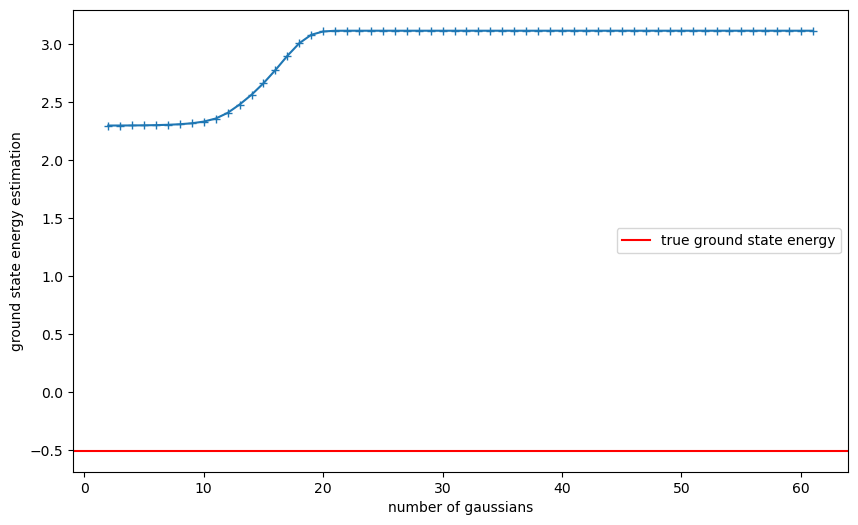

In [15]:
fig = plt.figure(figsize=[10,6])
plt.plot(num_gaussians, rms_values, marker = '+')
plt.axhline(-0.504, label = 'true ground state energy', color='r')

plt.xlabel('number of gaussians')
plt.ylabel('ground state energy estimation')
plt.legend()
plt.show()